<a href="https://colab.research.google.com/github/Alkahapur/CNN-Models/blob/main/AVEC2013_Regression_v1_Reproduced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import numpy as np
import os
import pandas as pd
import glob
import librosa
import sys
import seaborn as sns
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
np.random.seed(42)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GaussianNoise, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, LSTM, GRU, Bidirectional
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /gdrive



Mounted at /content/gdrive
[Errno 2] No such file or directory: '/gdrive'
/content


In [7]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [4]:
wd = os.path.join("/content/gdrive/MyDrive/Lifeback/AVEC_2013")
wd
train_audio_dir = os.path.join(wd, 'Training')
train_labels_dir = os.path.join(wd, 'Training_DepressionLabels')

dev_audio_dir = os.path.join(wd, 'Development')
dev_labels_dir = os.path.join(wd, 'Development_DepressionLabels')

test_audio_dir = os.path.join(wd, 'Testing_Audio')

In [5]:
print ("Train: Number of audio files = %d, Number of labels = %d" %(len(os.listdir(train_audio_dir)), len(train_labels_dir)))
print ("Development: Number of audio files = %d, Number of labels = %d" %(len(os.listdir(dev_audio_dir)), len(dev_labels_dir)))

Train: Number of audio files = 50, Number of labels = 68
Development: Number of audio files = 51, Number of labels = 71


In [6]:
print ("Number of Test files %d" %len(os.listdir(test_audio_dir)))

Number of Test files 50


In [7]:
train_paths = []
train_labels = []

train_audio_files = os.listdir(train_audio_dir)

for i in range(len(train_audio_files)):
  audio_file = train_audio_files[i]
  id = '_'.join(audio_file.split('_')[:2])
  
  label_file = id + "_Depression.csv"
  with open(os.path.join(train_labels_dir,label_file),'r') as f:
    label = int(f.read())

  path1 = os.path.join(train_audio_dir,audio_file)
  #print (audio_file, id, label, path1)

  if path1 not in train_paths:
    if (not os.path.isfile(path1)):
      print ("%s does not exist" %path1)
    else:
      train_paths.append(path1)
      train_labels.append(label)

print ("Training set has a total of %d unique labelled clips" %len(train_paths))

Training set has a total of 50 unique labelled clips


In [8]:
dev_paths = []
dev_labels = []

dev_audio_files = os.listdir(dev_audio_dir)

for i in range(len(dev_audio_files)):
  audio_file = dev_audio_files[i]
  id = '_'.join(audio_file.split('_')[:2])
  
  label_file = id + "_Depression.csv"
  with open(os.path.join(dev_labels_dir,label_file),'r') as f:
    label = int(f.read())

  path1 = os.path.join(dev_audio_dir,audio_file)
  #print (audio_file, id, label, path1)

  if path1 not in dev_paths:
    if (not os.path.isfile(path1)):
      print ("%s does not exist" %path1)
    else:
      dev_paths.append(path1)
      dev_labels.append(label)

print ("Development set has a total of %d unique labelled clips" %len(dev_paths))

Development set has a total of 51 unique labelled clips


In [9]:

train_data = pd.DataFrame({'Path':train_paths, 'BDI':train_labels})
dev_data = pd.DataFrame({'Path':dev_paths, 'BDI':dev_labels})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


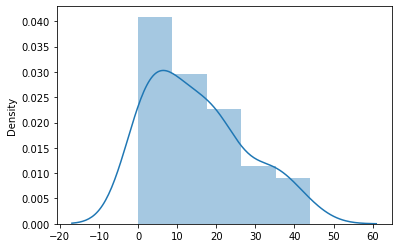

In [10]:
sns.distplot(train_data['BDI'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


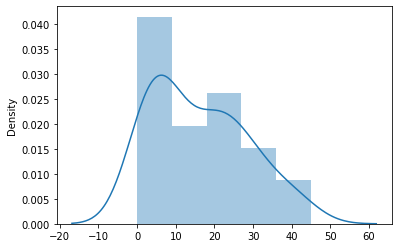

In [11]:
sns.distplot(dev_data['BDI'].values)

In [13]:

def clip_audio(audio, sr, t_min, t_max):
    segment_start = np.int(np.floor(sr*t_min))
    segment_end = np.int(np.ceil(sr*t_max))
    return audio[segment_start:segment_end]

In [14]:
def mel_spectrogram(audio, sr, n_mels = 90):
    melspec = librosa.feature.melspectrogram(
        audio, sr=sr, n_mels=n_mels
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

In [15]:

X = []
y = []

SEGMENT_SIZE = 60 
SEGMENT_STRIDE = 30
INPUT_SHAPE = 256

paths = train_data['Path'].values
labels = train_data['BDI'].values

start_time = time.time()
for i in range(len(paths)):
  path = paths[i]
  label = labels[i]

  audio, sr = librosa.core.load(path)
  duration = audio.shape[0]/sr

  t_min = 0
  finish = False
  print ("Dividing audio %d" %(i+1))
  while t_min < duration:
    t_max = t_min + SEGMENT_SIZE
    
    if t_max > duration:
      t_max = duration
      finish = True

    audio_clipped = clip_audio(audio, sr, t_min, t_max)
    mel_spec = mel_spectrogram(audio_clipped, sr)
    
    img = tf.image.resize(mel_spec[...,np.newaxis],(INPUT_SHAPE, INPUT_SHAPE))

    X.append(img)
    y.append(label)

    if finish==True:
      break

    t_min = t_min + SEGMENT_STRIDE

X = np.array(X)
y = np.array(y)

print (X.shape, y.shape)

end_time = time.time()
print ("Time taken = %.3f minutes" %((end_time-start_time)/60))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 1


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 2


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 3


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 4


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 5


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 6


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 7


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 8


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 9


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 10


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 11


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 12


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 13


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 14


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 15


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 16


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 17


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 18


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 19


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 20


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 21


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 22


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 23


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 24


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 25


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 26


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 27


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 28


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 29


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 30


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 31


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 32


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 33


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 34


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 35


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 36


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 37


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 38


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 39


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 40


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 41


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 42


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 43


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 44


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 45


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 46


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 47


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 48


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 49


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 50
(1567, 256, 256, 1) (1567,)
Time taken = 31.628 minutes


In [16]:
train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)
print (train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)

(1253, 256, 256, 1) (1253,) (314, 256, 256, 1) (314,)


In [17]:

def create_model(input_shape = (INPUT_SHAPE,INPUT_SHAPE,1)):
  model = Sequential()
  model.add(Input(shape = input_shape))
   
  model.add(Conv2D(32, (5,5), kernel_initializer = 'he_normal', padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  
  model.add(Conv2D(64, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
  #model.add(GaussianNoise(0.3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, kernel_size = (3,3),  padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(0.2))


  model.add(Flatten())

  model.add(Dense(512, kernel_initializer = 'he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  model.add(Dense(64))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  #model.add(Dense(1, activation = 'sigmoid'))
  model.add(Dense(1, activation = 'linear'))

  optim = Adam(learning_rate = 0.0007)
  model.compile(loss = 'mse', optimizer = optim, metrics = ['mae'])
  #model.summary()
  return model

In [18]:
train_generator = ImageDataGenerator(width_shift_range=0.2,
                                      zoom_range = 0.2, 
                                     horizontal_flip = True
                                     )

model = create_model()  
model_checkpoint = os.path.join(wd, 'baseline_model.hdf5')
cp = ModelCheckpoint(model_checkpoint, monitor = 'val_loss', mode = 'auto', verbose = 0, save_best_only = True)

lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=5, verbose=0,
    mode='auto')

callbacks = [cp, lr]


history = model.fit(train_generator.flow(train_x, train_y, batch_size = 32), epochs = 70, callbacks = callbacks, validation_data = (valid_x, valid_y))

Epoch 1/70
40/40 [==============================] - 16s 188ms/step - loss: 314.4380 - mae: 13.8647 - val_loss: 865.2402 - val_mae: 27.1450
Epoch 2/70
40/40 [==============================] - 7s 173ms/step - loss: 314.0455 - mae: 13.9921 - val_loss: 343.9702 - val_mae: 14.7515
Epoch 3/70
40/40 [==============================] - 7s 177ms/step - loss: 282.1486 - mae: 13.1455 - val_loss: 275.5070 - val_mae: 12.8125
Epoch 4/70
40/40 [==============================] - 7s 173ms/step - loss: 228.6117 - mae: 11.6018 - val_loss: 240.4373 - val_mae: 11.6487
Epoch 5/70
40/40 [==============================] - 7s 175ms/step - loss: 207.9913 - mae: 11.0314 - val_loss: 185.6389 - val_mae: 9.8587
Epoch 6/70
40/40 [==============================] - 7s 174ms/step - loss: 182.9815 - mae: 10.2921 - val_loss: 208.8221 - val_mae: 11.0323
Epoch 7/70
40/40 [==============================] - 7s 183ms/step - loss: 163.6060 - mae: 9.6699 - val_loss: 244.3720 - val_mae: 12.0130
Epoch 8/70
40/40 [=================

In [19]:
def plot_history(history):
    fig, axs = plt.subplots(1,2, figsize = (15,6))
    axs[0].plot(history.history['mae'])
    axs[0].plot(history.history['val_mae'])
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].set_ylim(3,10)
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_ylabel('MSE')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper right')

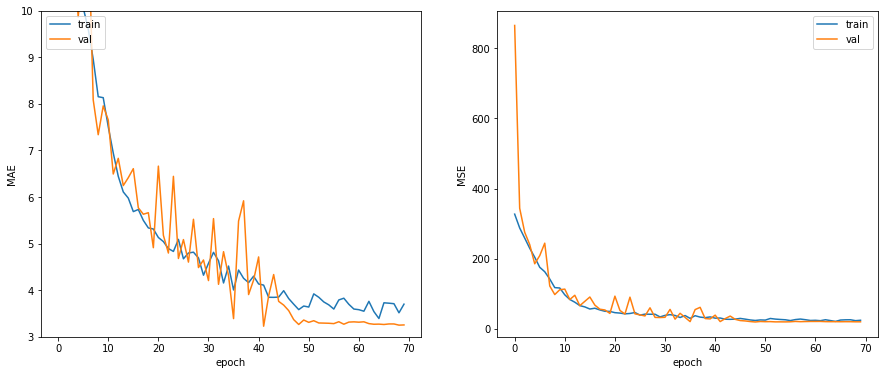

In [20]:
plot_history(history)


In [21]:
model = load_model(model_checkpoint)
model.evaluate(valid_x, valid_y)

10/10 [==============================] - 0s 33ms/step - loss: 19.6584 - mae: 3.2645


[19.658411026000977, 3.2645387649536133]

In [22]:

def predict_test(model, test_paths, segmentation = True, SEGMENT_SIZE = 60, SEGMENT_STRIDE = 30, img_size = 256):
  preds = []
  for i,path in enumerate(test_paths):
    audio, sr = librosa.load(path)
    duration = audio.shape[0]/sr

    if segmentation==False:
      mel_spec = mel_spectrogram(audio, sr)
      x = tf.image.resize(mel_spec[...,np.newaxis], (img_size, img_size))
      x = x[np.newaxis,...]

      y_hat = model.predict(x)
      preds.append(y_hat)
    
    else:
      temp = []
      t_min = 0
      finish = False
      
      print ("Dividing audio %d" %(i+1))
      while t_min < duration:
        t_max = t_min + SEGMENT_SIZE
        
        if t_max > duration:
          t_max = duration
          finish = True

        audio_clipped = clip_audio(audio, sr, t_min, t_max)
        mel_spec = mel_spectrogram(audio_clipped, sr)
        
        img = tf.image.resize(mel_spec[...,np.newaxis],(img_size, img_size))

        temp.append(img)

        if finish==True:
          break

        t_min = t_min + SEGMENT_STRIDE

      temp = np.array(temp)
      y_hat = model.predict(temp)
      
      
      y_hat = np.mean(y_hat)
      preds.append(y_hat)
      

  return preds

In [23]:
test_paths = dev_data['Path'].values
test_labels = dev_data['BDI'].values

In [24]:
test_preds = predict_test(model, test_paths)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 1


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 2


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 3


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 4


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 5


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 6


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 7


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 8


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 9


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 10


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 11


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 12


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 13


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 14


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 15


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 16


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 17


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 18


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 19


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 20


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 21


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 22


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 23


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 24


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 25


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 26


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 27


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 28


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 29


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 30


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 31


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 32


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 33


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 34


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 35


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 36


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 37


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 38


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 39


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 40


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 41


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 42


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 43


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 44


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 45


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 46


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 47


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 48


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 49


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 50


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Dividing audio 51


In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def evaluate_test(test_y, test_pred):
  mse = mean_squared_error(test_y, test_pred)
  mae = mean_absolute_error(test_y, test_pred)
  r2 = r2_score(test_y, test_pred)

  print ("RMSE = %.3f" %(np.sqrt(mse)))
  print ("MAE  = %.3f" %mae)
  print ("R2   = %.3f" %r2)

In [26]:
evaluate_test(test_labels, test_preds)

RMSE = 9.667
MAE  = 7.999
R2   = 0.375


In [28]:
np.corrcoef(test_labels, test_preds)[0,1]**2

0.387302390823768

In [ ]:

sns.boxplot(x = test_labels, y = test_preds )
plt.xlabel("Test Labels")
plt.ylabel("Predicted labels")
plt.show()